In [59]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
import torch

import schedule

In [1]:

import time
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
import torch

import schedule

def to_day_update():
    dataset = pd.read_csv('data/donotopensi.csv', index_col = 0)
    data = dataset.set_index('date')
    data = data.sort_values('date')
    def create_sequences(data, seq_length):
        xs = []
        ys = []
        for i in range(len(data)-seq_length):
            x = data.iloc[i:(i+seq_length)]
            y = data.iloc[i+seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    seq_length = 5
    X, y = create_sequences(data, seq_length)

    X.shape, y.shape

    train_size = int(2267 * 0.8)
    print(train_size)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+227], y[train_size:train_size+227]
    X_test, y_test = X[train_size+227:], y[train_size+227:]

    print(X_train.shape, X_val.shape, X_test.shape)
    print(y_train.shape, y_val.shape, y_test.shape)

    MIN = X_train.min()
    MAX = X_train.max()
    print(MIN, MAX)

    def MinMaxScale(array, min, max):

        return (array - min) / (max - min)

    X_train = MinMaxScale(X_train, MIN, MAX)
    y_train = MinMaxScale(y_train, MIN, MAX)
    X_val = MinMaxScale(X_val, MIN, MAX)
    y_val = MinMaxScale(y_val, MIN, MAX)
    X_test = MinMaxScale(X_test, MIN, MAX)
    y_test = MinMaxScale(y_test, MIN, MAX)

    def make_Tensor(array):
        return torch.from_numpy(array).float()

    X_train = make_Tensor(X_train)
    y_train = make_Tensor(y_train)
    X_val = make_Tensor(X_val)
    y_val = make_Tensor(y_val)
    X_test = make_Tensor(X_test)
    y_test = make_Tensor(y_test)

    import torch
    import os
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    import seaborn as sns
    from pylab import rcParams
    import matplotlib.pyplot as plt
    from matplotlib import rc
    from sklearn.preprocessing import MinMaxScaler
    from pandas.plotting import register_matplotlib_converters
    from torch import nn, optim

    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    sns.set(style='whitegrid', palette='muted', font_scale=1.2)
    rcParams['figure.figsize'] = 14, 10
    register_matplotlib_converters()
    RANDOM_SEED = 42
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)


    class Wheat(nn.Module):
        def __init__(self, n_features, n_hidden, seq_len, n_layers):
            super(Wheat, self).__init__()
            self.n_hidden = n_hidden
            self.seq_len = seq_len
            self.n_layers = n_layers
            self.lstm = nn.LSTM(
                input_size=n_features,
                hidden_size=n_hidden,
                num_layers=n_layers
            )
            self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
            )
        def forward(self, sequences):
            lstm_out, self.hidden = self.lstm(
                sequences.view(len(sequences), self.seq_len, -1),
                self.hidden
            )
            last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
            y_pred = self.linear(last_time_step)
            return y_pred

    def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
        loss_fn = torch.nn.L1Loss() #
        optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
        train_hist = []
        val_hist = []
        for t in range(num_epochs):

            epoch_loss = 0

            for idx, seq in enumerate(train_data): 

                model.reset_hidden_state() # seq 별 hidden state reset

                # train loss
                seq = torch.unsqueeze(seq, 0)
                y_pred = model(seq)
                loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

                # update weights
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()

                epoch_loss += loss.item()

            train_hist.append(epoch_loss / len(train_data))

            if val_data is not None:

                with torch.no_grad():

                    val_loss = 0

                    for val_idx, val_seq in enumerate(val_data):

                        model.reset_hidden_state() # seq 별로 hidden state 초기화 

                        val_seq = torch.unsqueeze(val_seq, 0)
                        y_val_pred = model(val_seq)
                        val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                        val_loss += val_step_loss
                    
                val_hist.append(val_loss / len(val_data)) # val hist에 추가

                ## verbose 번째 마다 loss 출력 
                if t % verbose == 0:
                    print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

                ## patience 번째 마다 early stopping 여부 확인
                if (t % patience == 0) & (t != 0):
                    
                    ## loss가 커졌다면 early stop
                    if val_hist[t - patience] < val_hist[t] :

                        print('\n Early Stopping')

                        break

            elif t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

                
        return model, train_hist, val_hist


    model = Wheat(
        n_features=1,
        n_hidden=4,
        seq_len=seq_length,
        n_layers=1
    )
    model, train_hist, val_hist = train_model(
        model,
        X_train,
        y_train,
        X_val,
        y_val,
        num_epochs=100,
        verbose=10,
        patience=50
    )


    pred_dataset = X_test

    with torch.no_grad():
        preds = []
        for _ in range(len(pred_dataset)):
            model.reset_hidden_state()
            y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)

    plt.plot(data.index[-len(y_test):], np.array(y_test) * MAX, label='True')
    plt.plot(data.index[-len(preds):], np.array(preds) * MAX, label='Pred')
    plt.gca().axes.yaxis.set_visible(False) 
    plt.xticks(rotation=45)
    plt.legend()


    def MAE(true, pred):
        return np.mean(np.abs(true-pred))


    MAE(np.array(y_test)*MAX, np.array(preds)*MAX)


    with torch.no_grad():
        test_seq = X_test[:1] # 첫번째 테스트 셋, 3차원
        preds = []
        for _ in range(len(X_test)):
            model.reset_hidden_state()
            y_test_pred = model(test_seq)
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred]) # 시퀀스에 추가 
            new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length가 5개가 되도록 맞추기 
            test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

    plt.plot(data.index[-len(y_test):], np.array(y_test) * MAX, label='True')
    plt.plot(data.index[-len(preds):], np.array(preds) * MAX, label='Pred')
    plt.xticks(rotation=45)
    plt.gca().axes.xaxis.set_visible(False)
    plt.legend()

    plt.savefig('sin.png', dpi=300)

def message1():
    print("스케쥴 실행중...")



coll = schedule.every(1).seconds.do(message1)
refresh = schedule.every().day.at("00:10").do(to_day_update) #매일 00시 10분에 Refresh

while True:
    schedule.run_pending()
    time.sleep(1)

C:\Users\2005k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...
스케쥴 실행중...


In [76]:

import time
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
import torch

import schedule

dataset = pd.read_csv('data/donotopensi.csv', index_col = 0)
data = dataset.set_index('date')
data = data.sort_values('date')
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(data, seq_length)

X.shape, y.shape

train_size = int(2267 * 0.8)
print(train_size)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+227], y[train_size:train_size+227]
X_test, y_test = X[train_size+227:], y[train_size+227:]

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

MIN = X_train.min()
MAX = X_train.max()
print(MIN, MAX)

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


class Wheat(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(Wheat, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist


model = Wheat(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)


pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

plt.plot(data.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(data.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.gca().axes.yaxis.set_visible(False) 
plt.xticks(rotation=45)
plt.legend()


def MAE(true, pred):
    return np.mean(np.abs(true-pred))


MAE(np.array(y_test)*MAX, np.array(preds)*MAX)


with torch.no_grad():
    test_seq = X_test[:1] # 첫번째 테스트 셋, 3차원
    preds = []
    for _ in range(len(X_test)):
        model.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # 시퀀스에 추가 
        new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length가 5개가 되도록 맞추기 
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

plt.plot(data.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(data.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.gca().axes.xaxis.set_visible(False)
plt.legend()

plt.savefig('sin.png', dpi=300)


1813
(1813, 5, 1) (227, 5, 1) (227, 5, 1)
(1813, 1) (227, 1) (227, 1)
430.255 935.595
Hello!
Hello!
Hello!
Hello!
Epoch 0 train loss: 0.062199950855178064 val loss: 0.07338131964206696
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Epoch 10 train loss: 0.017717670709391984 val loss: 0.032376792281866074
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!
Hello!


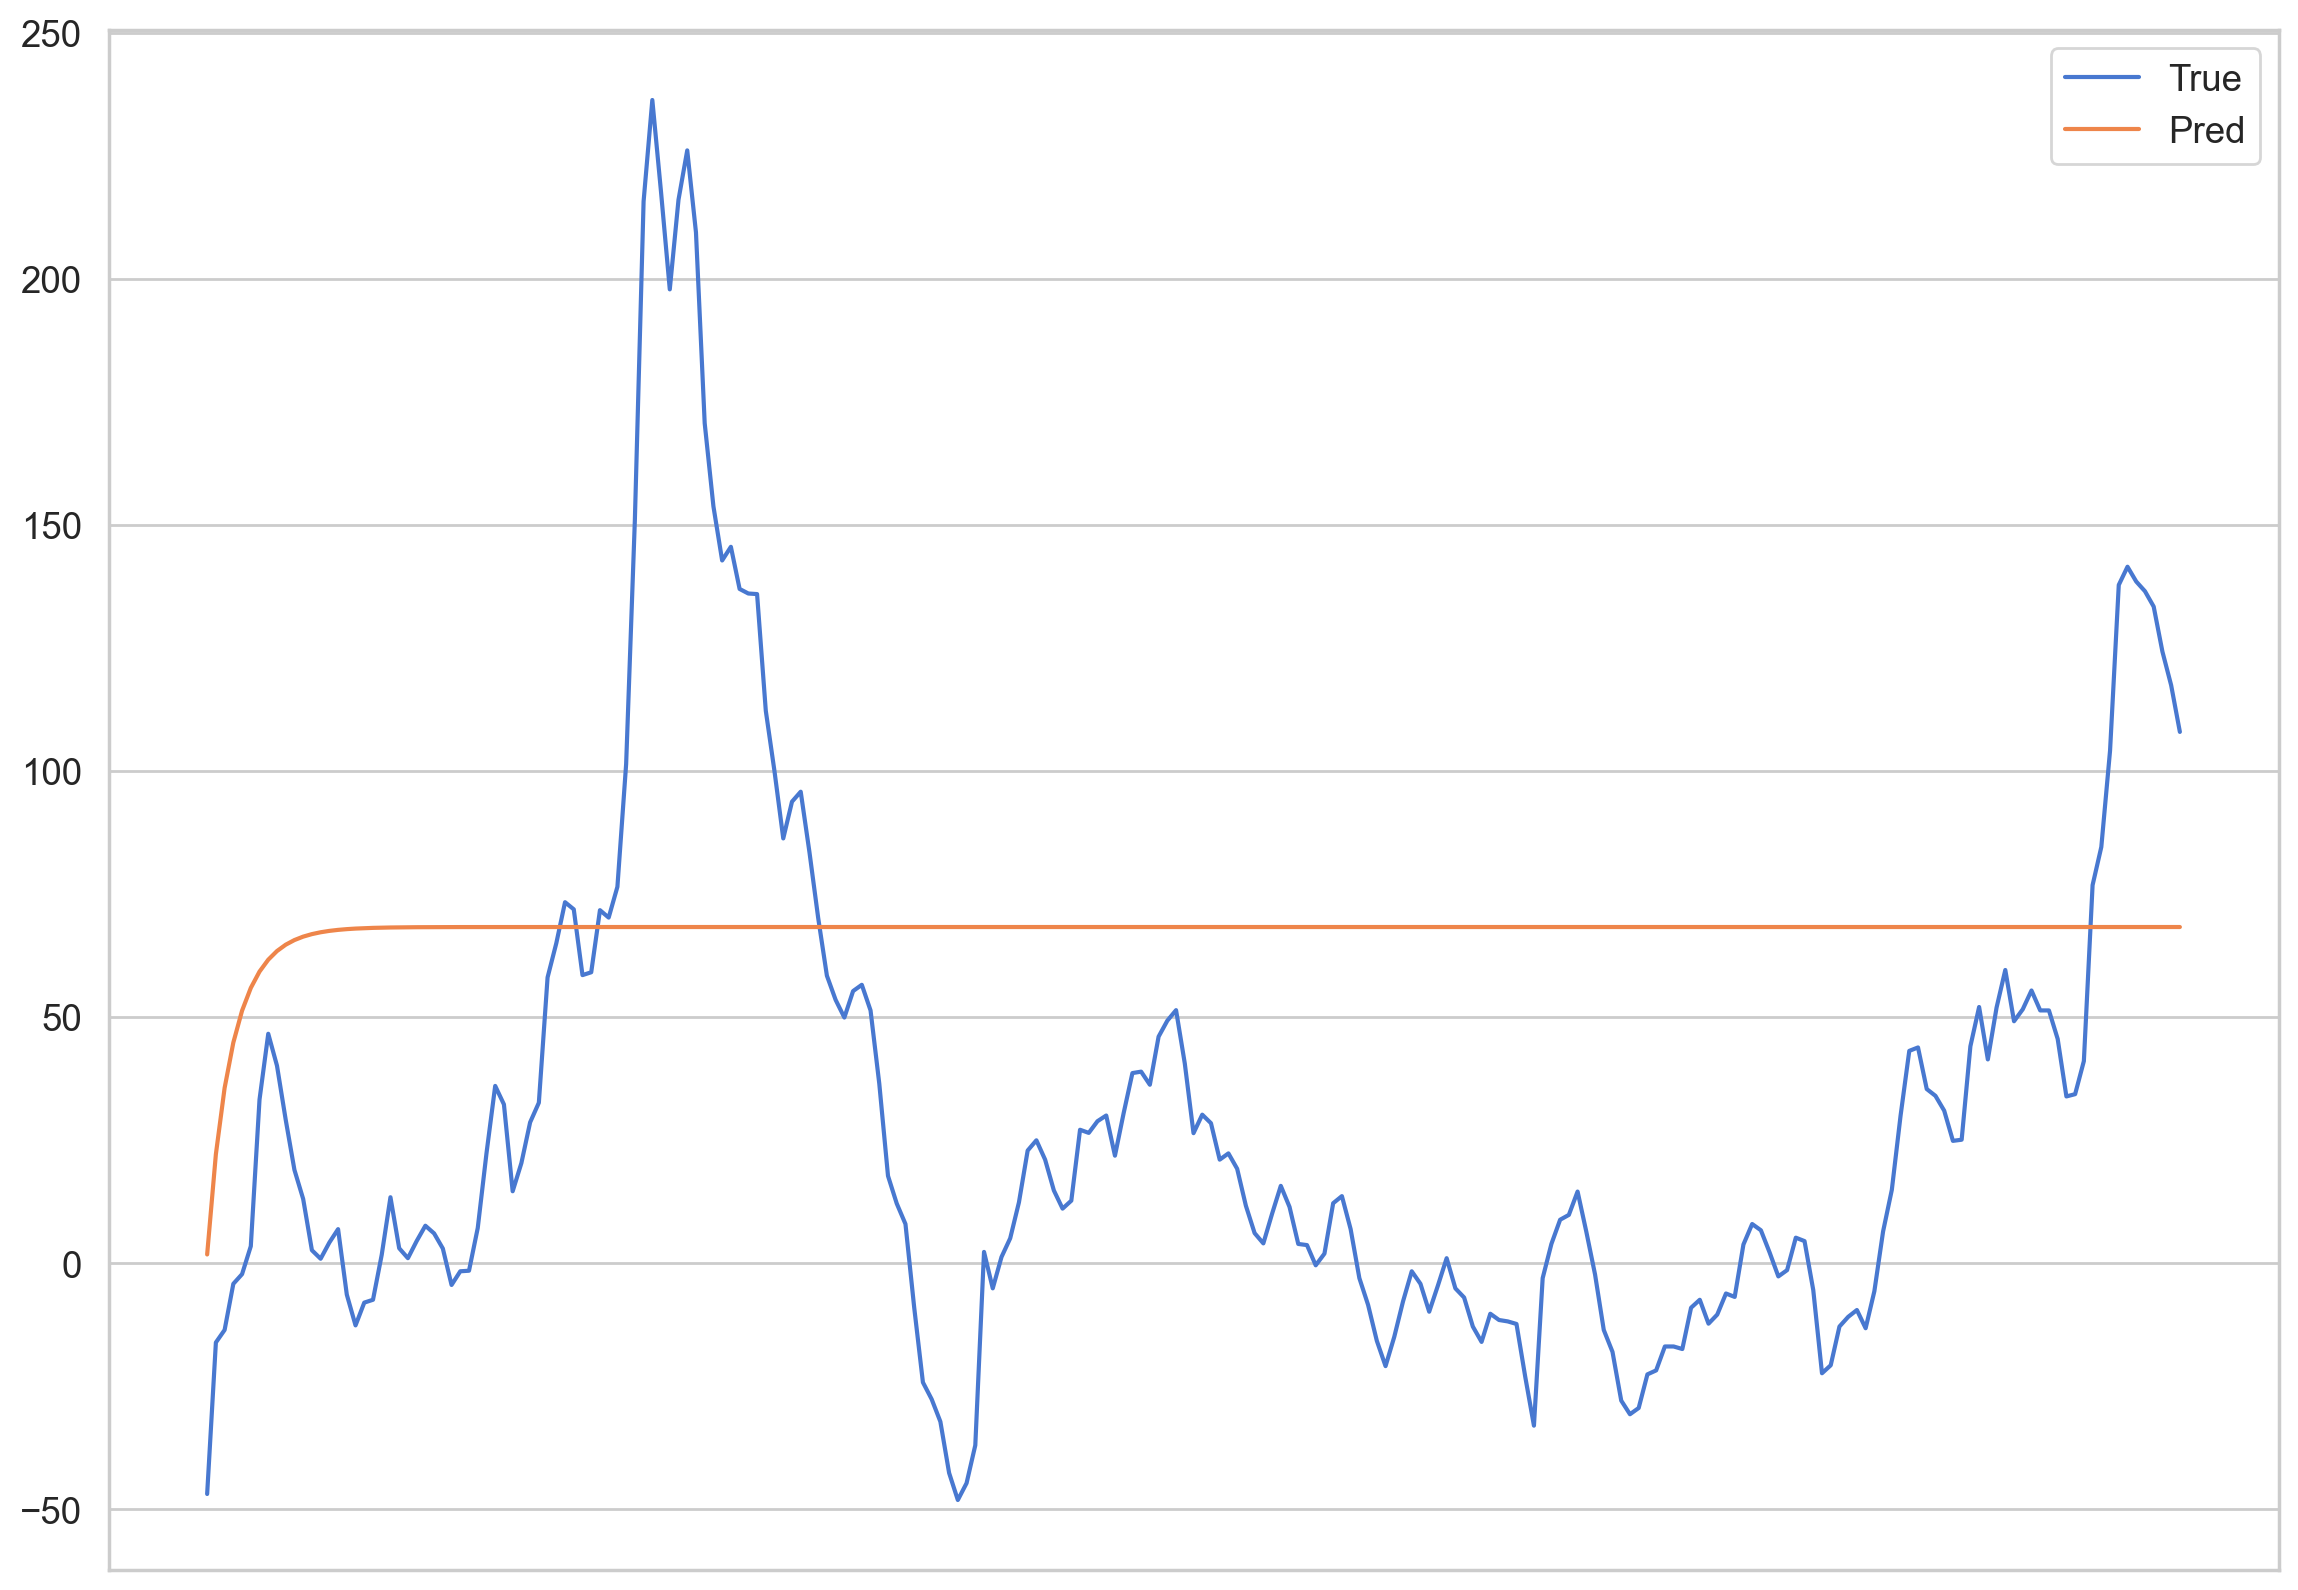

In [45]:
plt.plot(data.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(data.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.gca().axes.xaxis.set_visible(False)
plt.legend()

plt.savefig('sin.png', dpi=300)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 12)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\2005k\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
